In [1]:
# Importing packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchmetrics
import torchinfo
import torch.nn.functional as F
import cv2
from torchsummary import summary

In [2]:
# Data pathes
train_images = '../DATASETS/DRIVE/training/images/'
train_labels = '../DATASETS/DRIVE/training/1st_manual/'
val_images = '../DATASETS/DRIVE/test/images/'
val_labels = '../DATASETS/DRIVE/test/1st_manual/'

[  0 255]
(584, 565)


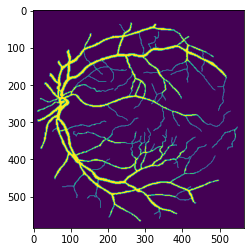

In [3]:
label = os.path.join(train_labels, sorted(os.listdir(train_labels))[5])
plt.imshow(Image.open(label))
label = np.array(Image.open(label))
print(np.unique(label))
print(np.shape(label))


In [4]:
def show_img(images_path, labels_path, num):
    img = Image.open(os.path.join(images_path, sorted(os.listdir(images_path))[num]))
    mask = Image.open(os.path.join(labels_path, sorted(os.listdir(labels_path))[num]))

    fig = plt.figure()
    rows=1
    columns=2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.title("Image")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(mask)
    plt.title("Mask")


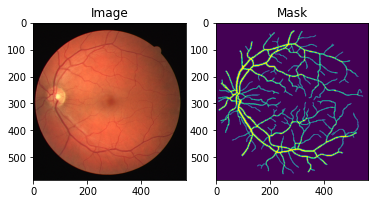

In [9]:
import random
show_img(train_images, train_labels, random.randint(0, 19))

In [11]:
# Hyperparams
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
IN_CHANNELS = 3
CLASSES = 2
TRAIN_BATCH = 2
VALID_BATCH = 1
NUM_WORKERS = 2
LR = 0.001
EPOCHS = 50

In [12]:
# Train and test augmentations

A_train = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
                     A.OneOf([
                       A.VerticalFlip(p=1),
                       A.HorizontalFlip(p=1),
                       A.RandomRotate90(p=1)], p=1),  
                    # A.Normalize(
                    #             mean=[0.4973, 0.2706, 0.1624], 
                    #             std = [0.3318, 0.1785, 0.0989],
                    #             max_pixel_value=255.0),
                  ToTensorV2()])


A_val =  A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
                    #  A.Normalize(
                    #             mean=[0.4973, 0.2706, 0.1624], 
                    #             std = [0.3318, 0.1785, 0.0989],
                    #             max_pixel_value=255.0),
                    
                   ToTensorV2()])

In [13]:
# Dataset class
class DriveDataset(Dataset):
    def __init__(self, img_path, mask_path, transforms=None, training=True):
        super(DriveDataset, self).__init__()
        self.img_path = img_path
        self.mask_path = mask_path
        self.transforms = transforms
        self.training = training
        self.images_list = sorted(os.listdir(img_path))

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, index):
        path=os.path.join(self.img_path, self.images_list[index])
        image = np.array(Image.open(path).convert("RGB"))
        if self.training:
            path = os.path.join(self.mask_path, self.images_list[index].replace('_training.tif', '_manual1.gif'))
            mask = np.array(Image.open(path).convert("L"), dtype=np.float32)
        else:
            path = os.path.join(self.mask_path, self.images_list[index].replace('_test.tif', '_manual1.gif'))
            mask = np.array(Image.open(path).convert("L"), dtype=np.float32)
        mask[mask==255] = 1.0

        if self.transforms is not None:
            aug  = self.transforms(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        return image, mask

In [14]:
# Datasets and Dataloaders

train_set = DriveDataset(train_images, train_labels, transforms=A_train, training=True)
valid_set = DriveDataset(val_images, val_labels, transforms=A_val, training=False)


train_loader = DataLoader(train_set, shuffle=True, batch_size=TRAIN_BATCH)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=VALID_BATCH)

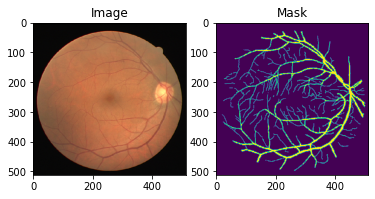

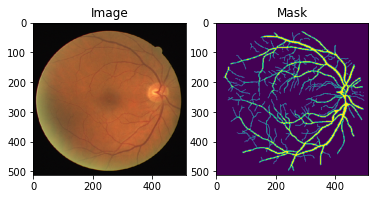

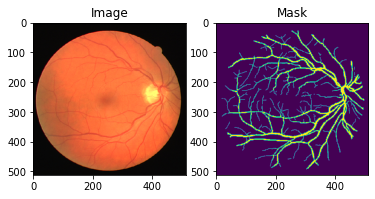

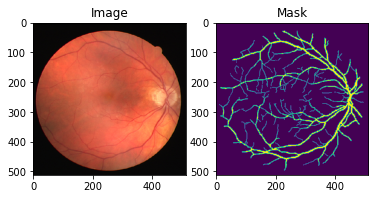

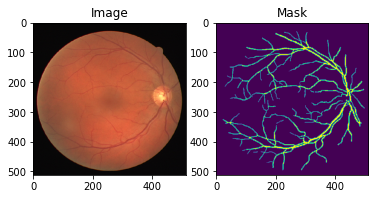

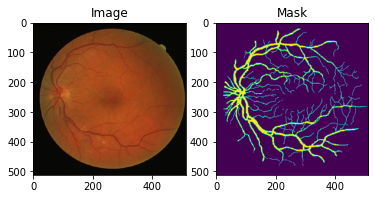

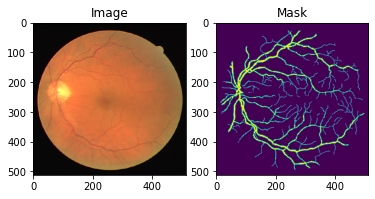

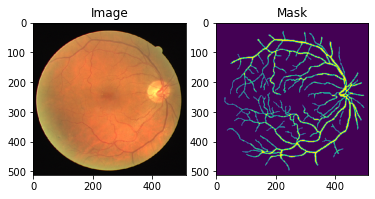

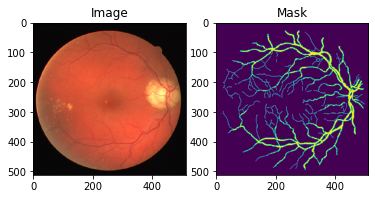

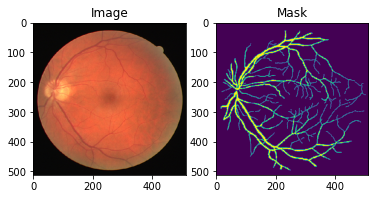

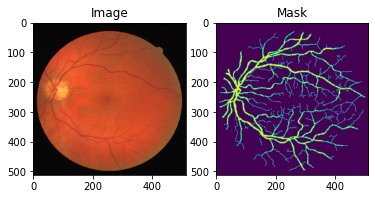

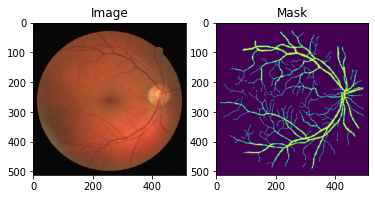

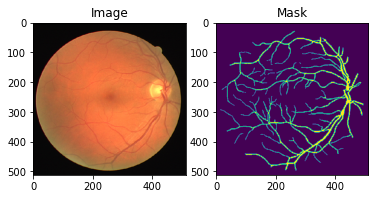

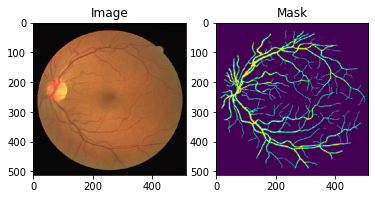

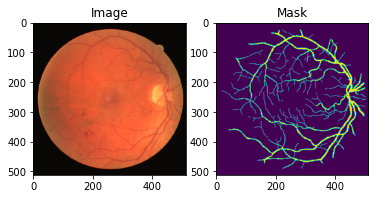

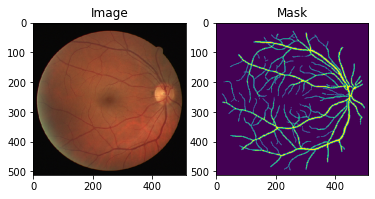

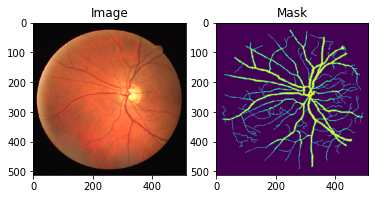

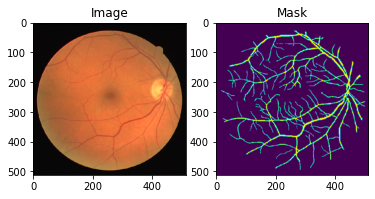

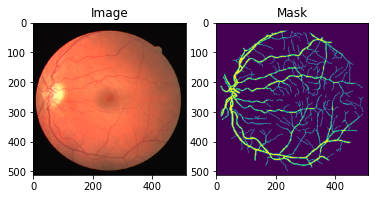

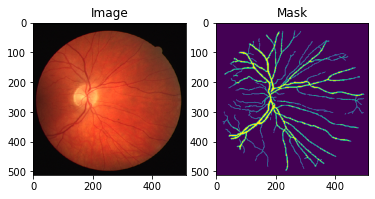

In [41]:
for index, data in enumerate(valid_loader):
    imgs, masks = data
    fig = plt.figure()
    rows=1
    columns=2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(imgs[0].permute(1, 2, 0))
    plt.title("Image")

    fig.add_subplot(rows, columns, 2)
    plt.imshow(masks[0].float())
    plt.title("Mask") 

In [15]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.float().view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    return mean, std

mean, std = get_mean_and_std(train_loader)
mean, std = mean/255, std/255
print(mean)
print(std)

tensor([0.4974, 0.2707, 0.1624])
tensor([0.3316, 0.1783, 0.0987])


Text(0.5, 1.0, 'Mask')

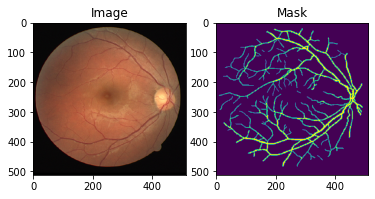

In [17]:
data = next(iter(train_loader))
imgs, labels = data

# Show image and corresponding mask side by side
fig = plt.figure()
rows=1
columns=2
fig.add_subplot(rows, columns, 1)
plt.imshow(imgs[0].permute(1,2,0))
plt.title("Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(labels[0])
plt.title("Mask")

In [18]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data.float(), dim=[0,2,3])
        channels_squared_sum += torch.mean(data.float()**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(train_loader)
print(mean/255)
print(std/255)

tensor([0.4974, 0.2707, 0.1624])
tensor([0.3481, 0.1900, 0.1078])


In [19]:
img, mask = train_set[2]

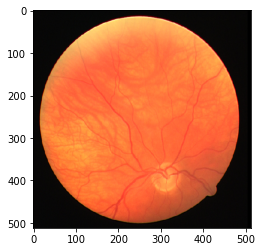

In [20]:
plt.imshow(img.permute(1, 2, 0))

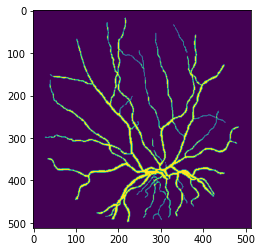

In [21]:
plt.imshow(mask)

In [22]:
print(np.unique(mask))

[0. 1.]


In [23]:
import torch 
import torch.nn as nn
from torch.nn.modules.conv import Conv2d

# Skip connection 
class Residual(nn.Module):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


# In this block we have n depth and in_dim and out_dim is equal. We will use it for the path aggregation.
def ConvMixer_Path(dim, depth, kernel_size=3, padding=1):
    return nn.Sequential(
        *[nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(dim, dim, kernel_size=kernel_size, groups=dim, padding=padding),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                
            )),
            nn.Conv2d(dim, dim, kernel_size=1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            
        ) for i in range(depth)]
    )

# In this block the depth is 1 and in_dim and out_dim is different. We will use this block in every stage of the U_Net
def ConvMixer_Block(in_dim, out_dim, kernel_size=3, padding=1):
    return nn.Sequential(
            Residual(nn.Sequential(
                nn.Conv2d(in_dim, in_dim, kernel_size=kernel_size, groups=in_dim, padding=padding),
                nn.BatchNorm2d(in_dim),
                nn.ReLU()
            )),
            nn.Conv2d(in_dim, out_dim, kernel_size=1),
        nn.BatchNorm2d(out_dim),    
        nn.ReLU()
    )


class DepthWiseInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1)
        self.conv3_1 = ConvMixer_Block(in_channels, int(out_channels/4))
        self.conv3_2 = ConvMixer_Block(out_channels//4, int(out_channels/4))
        self.conv3_3 = ConvMixer_Block(out_channels//4, int(out_channels/4))
#         self.conv5 = nn.Sequential(ConvMixer_Block(in_channels, int(out_channels/4)),
#                                     ConvMixer_Block(int(out_channels/4), int(out_channels/4)))
#         self.conv7 = nn.Sequential(ConvMixer_Block(in_channels, int(out_channels/4)),
#                                     ConvMixer_Block(int(out_channels/4), int(out_channels/4)),
#                                     ConvMixer_Block(int(out_channels/4), int(out_channels/4)))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        a = self.conv1(x)
        b = self.conv3_1(x)
        c = self.conv3_2(b)
        d = self.conv3_3(c)

        cat = torch.cat([a, b, c, d], dim=1)
        x = self.batchnorm(cat)
        out = self.relu(cat)
       

        return out
#######################################



class ConvMixer_UNET_down(nn.Module):
    def __init__(self, num_classes):
        super(ConvMixer_UNET_down, self).__init__()
        self.num_classes = num_classes
        # Encoder Stage 1
        self.E_S1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  DepthWiseInceptionBlock(64, 64))
        # self.S1_path = ConvMixer_Path(64, 4)
        # self.S1_path_aggregate = Conv2d(64, 128, kernel_size=1) # The bottleneck layer that connects 1st stage path layer with second stage path

        self.E_S2 = nn.Sequential(DepthWiseInceptionBlock(64, 128),
                                  DepthWiseInceptionBlock(128, 128))

        # self.S2_path = ConvMixer_Path(128, 3)
        # self.S2_path_aggregate = Conv2d(128, 256, kernel_size=1)

        self.E_S3 = nn.Sequential(DepthWiseInceptionBlock(128, 256),
                                  DepthWiseInceptionBlock(256, 256))

        # self.S3_path = ConvMixer_Path(256, 2)
        # self.S3_path_aggregate = Conv2d(256, 512, kernel_size=1)

        self.E_S4 = nn.Sequential(DepthWiseInceptionBlock(256, 512),
                                  DepthWiseInceptionBlock(512, 512))

        # self.S4_path = ConvMixer_Path(512, 1)

        self.bridge = nn.Sequential(DepthWiseInceptionBlock(512, 1024),
                                    DepthWiseInceptionBlock(1024, 512))


        self.S4_up = nn.Sequential(#nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S3_up = nn.Sequential(#nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S2_up = nn.Sequential(#nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))
        self.S1_up = nn.Sequential(#nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),
                                   nn.UpsamplingBilinear2d(scale_factor=2))



        self.D_S4 = nn.Sequential(DepthWiseInceptionBlock(1024, 512),
                                    DepthWiseInceptionBlock(512, 256))

        self.D_S3 = nn.Sequential(DepthWiseInceptionBlock(512,256),
                                    DepthWiseInceptionBlock(256, 128))

        self.D_S2 = nn.Sequential(DepthWiseInceptionBlock(256, 128),
                                    DepthWiseInceptionBlock(128, 64))

        self.D_S1 = nn.Sequential(DepthWiseInceptionBlock(128, 64),
                                    DepthWiseInceptionBlock(64, 64))


        self.max_pool = nn.MaxPool2d(2, 2)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e_s1_out = self.E_S1(x)
        # s1_path_out = self.S1_path(e_s1_out)
        # s1_path_aggregation = self.S1_path_aggregate(self.max_pool(s1_path_out)) # this is the block that accepts 1st layer path output and maxpools it and then increases the number of channels twice to concatenate with second layer
        x = self.max_pool(e_s1_out) 

        e_s2_out = self.E_S2(x)
        # s2_path_out = self.S2_path(e_s2_out)
        # s2_path_aggregation = self.S2_path_aggregate(self.max_pool(s2_path_out))
        x = self.max_pool(e_s2_out)

        e_s3_out = self.E_S3(x)
        # s3_path_out = self.S3_path(e_s3_out)
        # s3_path_aggregation = self.S3_path_aggregate(self.max_pool(s3_path_out))
        x = self.max_pool(e_s3_out)

        e_s4_out = self.E_S4(x)
        # s4_path_out =self.S4_path(e_s4_out)
        x = self.max_pool(e_s4_out)
        
        bridge = self.bridge(x)

        s4_up = self.S4_up(bridge)
        cat = torch.cat([s4_up, e_s4_out], dim=1)
        d4_out = self.D_S4(cat)

        s3_up = self.S3_up(d4_out)
        cat = torch.cat([s3_up, e_s3_out], dim=1)
        d3_out = self.D_S3(cat)

        s2_up = self.S2_up(d3_out)
        cat = torch.cat([s2_up, e_s2_out], dim=1)
        d2_out = self.D_S2(cat)

        s1_up = self.S1_up(d2_out)
        cat = torch.cat([s1_up, e_s1_out], dim=1)
        d1_out = self.D_S1(cat)

        out = self.final(d1_out)  

        return out

In [24]:
# x = torch.rand(8, 32, 256, 256).to(DEVICE)
# model = DepthWiseInceptionBlock(in_channels=32, out_channels=32).to(DEVICE)
# out = model(x)
# print(out.shape)
model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
# summary(model, (3, 256, 256))

In [25]:
# Custom loss functions
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
#####################################################################################    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
#####################################################################################    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU
    
#####################################################################################    
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss
    
    
#####################################################################################
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [26]:
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
# criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss().to(DEVICE)
# criterion = DiceBCELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [27]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=CLASSES):
    with torch.no_grad():
        pred_mask = nn.functional.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [28]:
def plot_images(img, mask, pred):
    f, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[0].set_xlabel("Image")
    ax[1].imshow(mask)
    ax[1].set_xlabel("Ground Truth")
    ax[2].imshow(pred)
    ax[2].set_xlabel("Prediction")

  0%|          | 0/10 [00:00<?, ?it/s]/data1/hom1/ict11/.conda/envs/ict11-smp/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 20/20 [00:02<00:00,  7.24it/s, valid_loss=0.583, valid_miou=0.453]


Epoch-1 Train mean loss: 0.5216 Train MIOU: 0.4517
Epoch-1 Valid mean loss: 0.5823 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  7.33it/s, valid_loss=0.486, valid_miou=0.45] 


Epoch-2 Train mean loss: 0.3805 Train MIOU: 0.4569
Epoch-2 Valid mean loss: 0.4751 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  7.08it/s, valid_loss=0.328, valid_miou=0.455]


Epoch-3 Train mean loss: 0.2950 Train MIOU: 0.4568
Epoch-3 Valid mean loss: 0.3291 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  7.32it/s, valid_loss=0.302, valid_miou=0.45] 


Epoch-4 Train mean loss: 0.2500 Train MIOU: 0.4568
Epoch-4 Valid mean loss: 0.2786 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  7.13it/s, valid_loss=0.274, valid_miou=0.453]


Epoch-5 Train mean loss: 0.2241 Train MIOU: 0.4568
Epoch-5 Valid mean loss: 0.2770 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  6.82it/s, valid_loss=0.223, valid_miou=0.46] 


Epoch-6 Train mean loss: 0.2076 Train MIOU: 0.4568
Epoch-6 Valid mean loss: 0.2362 Valid MIOU: 0.4562


100%|██████████| 20/20 [00:02<00:00,  7.31it/s, valid_loss=0.213, valid_miou=0.496]


Epoch-7 Train mean loss: 0.1909 Train MIOU: 0.4693
Epoch-7 Valid mean loss: 0.2029 Valid MIOU: 0.4841


100%|██████████| 20/20 [00:02<00:00,  7.21it/s, valid_loss=0.238, valid_miou=0.496]


Epoch-8 Train mean loss: 0.1738 Train MIOU: 0.6147
Epoch-8 Valid mean loss: 0.1782 Valid MIOU: 0.6046


100%|██████████| 20/20 [00:02<00:00,  7.34it/s, valid_loss=0.215, valid_miou=0.665]


Epoch-9 Train mean loss: 0.1548 Train MIOU: 0.6847
Epoch-9 Valid mean loss: 0.1676 Valid MIOU: 0.6733


100%|██████████| 20/20 [00:04<00:00,  4.24it/s, valid_loss=0.175, valid_miou=0.648]


Epoch-10 Train mean loss: 0.1493 Train MIOU: 0.7068
Epoch-10 Valid mean loss: 0.1467 Valid MIOU: 0.7083


100%|██████████| 20/20 [00:02<00:00,  7.48it/s, valid_loss=0.188, valid_miou=0.696]


Epoch-11 Train mean loss: 0.1391 Train MIOU: 0.7238
Epoch-11 Valid mean loss: 0.1465 Valid MIOU: 0.7040


100%|██████████| 20/20 [00:02<00:00,  7.24it/s, valid_loss=0.119, valid_miou=0.766]


Epoch-12 Train mean loss: 0.1341 Train MIOU: 0.7305
Epoch-12 Valid mean loss: 0.1419 Valid MIOU: 0.7250


100%|██████████| 20/20 [00:03<00:00,  6.63it/s, valid_loss=0.134, valid_miou=0.751]


Epoch-13 Train mean loss: 0.1272 Train MIOU: 0.7450
Epoch-13 Valid mean loss: 0.1371 Valid MIOU: 0.7493


100%|██████████| 20/20 [00:03<00:00,  6.55it/s, valid_loss=0.205, valid_miou=0.685]


Epoch-14 Train mean loss: 0.1242 Train MIOU: 0.7540
Epoch-14 Valid mean loss: 0.1287 Valid MIOU: 0.7525


100%|██████████| 20/20 [00:02<00:00,  7.13it/s, valid_loss=0.114, valid_miou=0.79]  


Epoch-15 Train mean loss: 0.1253 Train MIOU: 0.7447
Epoch-15 Valid mean loss: 0.1247 Valid MIOU: 0.7567


100%|██████████| 20/20 [00:02<00:00,  6.78it/s, valid_loss=0.121, valid_miou=0.764]


Epoch-16 Train mean loss: 0.1198 Train MIOU: 0.7594
Epoch-16 Valid mean loss: 0.1253 Valid MIOU: 0.7460


100%|██████████| 20/20 [00:02<00:00,  6.78it/s, valid_loss=0.104, valid_miou=0.763] 


Epoch-17 Train mean loss: 0.1166 Train MIOU: 0.7614
Epoch-17 Valid mean loss: 0.1239 Valid MIOU: 0.7540


100%|██████████| 20/20 [00:02<00:00,  7.32it/s, valid_loss=0.146, valid_miou=0.72]  


Epoch-18 Train mean loss: 0.1154 Train MIOU: 0.7656
Epoch-18 Valid mean loss: 0.1220 Valid MIOU: 0.7442


100%|██████████| 20/20 [00:02<00:00,  7.40it/s, valid_loss=0.138, valid_miou=0.739] 


Epoch-19 Train mean loss: 0.1155 Train MIOU: 0.7653
Epoch-19 Valid mean loss: 0.1155 Valid MIOU: 0.7603


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_27161/3495382352.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 3)
100%|██████████| 20/20 [00:04<00:00,  4.23it/s, valid_loss=0.0857, valid_miou=0.801]


Epoch-20 Train mean loss: 0.1116 Train MIOU: 0.7702
Epoch-20 Valid mean loss: 0.1156 Valid MIOU: 0.7683


100%|██████████| 20/20 [00:03<00:00,  6.59it/s, valid_loss=0.118, valid_miou=0.741] 


Epoch-21 Train mean loss: 0.1114 Train MIOU: 0.7724
Epoch-21 Valid mean loss: 0.1161 Valid MIOU: 0.7715


100%|██████████| 20/20 [00:03<00:00,  6.53it/s, valid_loss=0.186, valid_miou=0.647] 


Epoch-22 Train mean loss: 0.1116 Train MIOU: 0.7715
Epoch-22 Valid mean loss: 0.1122 Valid MIOU: 0.7683


100%|██████████| 20/20 [00:02<00:00,  6.84it/s, valid_loss=0.0956, valid_miou=0.804]


Epoch-23 Train mean loss: 0.1110 Train MIOU: 0.7690
Epoch-23 Valid mean loss: 0.1155 Valid MIOU: 0.7726


100%|██████████| 20/20 [00:03<00:00,  6.35it/s, valid_loss=0.11, valid_miou=0.79]   


Epoch-24 Train mean loss: 0.1084 Train MIOU: 0.7809
Epoch-24 Valid mean loss: 0.1106 Valid MIOU: 0.7720


100%|██████████| 20/20 [00:02<00:00,  7.19it/s, valid_loss=0.123, valid_miou=0.772] 


Epoch-25 Train mean loss: 0.1082 Train MIOU: 0.7739
Epoch-25 Valid mean loss: 0.1147 Valid MIOU: 0.7666


100%|██████████| 20/20 [00:03<00:00,  6.63it/s, valid_loss=0.126, valid_miou=0.758] 


Epoch-26 Train mean loss: 0.1062 Train MIOU: 0.7815
Epoch-26 Valid mean loss: 0.1132 Valid MIOU: 0.7712


100%|██████████| 20/20 [00:02<00:00,  7.29it/s, valid_loss=0.0857, valid_miou=0.828]


Epoch-27 Train mean loss: 0.1075 Train MIOU: 0.7779
Epoch-27 Valid mean loss: 0.1108 Valid MIOU: 0.7738


100%|██████████| 20/20 [00:02<00:00,  6.91it/s, valid_loss=0.108, valid_miou=0.79]  


Epoch-28 Train mean loss: 0.1043 Train MIOU: 0.7813
Epoch-28 Valid mean loss: 0.1069 Valid MIOU: 0.7769


100%|██████████| 20/20 [00:02<00:00,  6.88it/s, valid_loss=0.106, valid_miou=0.79]  


Epoch-29 Train mean loss: 0.1036 Train MIOU: 0.7857
Epoch-29 Valid mean loss: 0.1077 Valid MIOU: 0.7735


100%|██████████| 20/20 [00:04<00:00,  4.41it/s, valid_loss=0.104, valid_miou=0.753] 


Epoch-30 Train mean loss: 0.1057 Train MIOU: 0.7808
Epoch-30 Valid mean loss: 0.1043 Valid MIOU: 0.7868


100%|██████████| 20/20 [00:02<00:00,  6.83it/s, valid_loss=0.0809, valid_miou=0.837]


Epoch-31 Train mean loss: 0.1044 Train MIOU: 0.7845
Epoch-31 Valid mean loss: 0.1091 Valid MIOU: 0.7720


100%|██████████| 20/20 [00:02<00:00,  7.37it/s, valid_loss=0.0924, valid_miou=0.806]


Epoch-32 Train mean loss: 0.1032 Train MIOU: 0.7850
Epoch-32 Valid mean loss: 0.1045 Valid MIOU: 0.7845


100%|██████████| 20/20 [00:02<00:00,  7.63it/s, valid_loss=0.174, valid_miou=0.672] 


Epoch-33 Train mean loss: 0.1017 Train MIOU: 0.7886
Epoch-33 Valid mean loss: 0.1068 Valid MIOU: 0.7757


100%|██████████| 20/20 [00:02<00:00,  6.92it/s, valid_loss=0.1, valid_miou=0.816]   


Epoch-34 Train mean loss: 0.1016 Train MIOU: 0.7869
Epoch-34 Valid mean loss: 0.1083 Valid MIOU: 0.7889


100%|██████████| 20/20 [00:02<00:00,  7.13it/s, valid_loss=0.0948, valid_miou=0.792]


Epoch-35 Train mean loss: 0.1034 Train MIOU: 0.7876
Epoch-35 Valid mean loss: 0.1079 Valid MIOU: 0.7726


100%|██████████| 20/20 [00:02<00:00,  6.79it/s, valid_loss=0.122, valid_miou=0.733] 


Epoch-36 Train mean loss: 0.1006 Train MIOU: 0.7893
Epoch-36 Valid mean loss: 0.1063 Valid MIOU: 0.7833


100%|██████████| 20/20 [00:02<00:00,  7.23it/s, valid_loss=0.0995, valid_miou=0.801]


Epoch-37 Train mean loss: 0.0991 Train MIOU: 0.7936
Epoch-37 Valid mean loss: 0.1007 Valid MIOU: 0.7850


100%|██████████| 20/20 [00:02<00:00,  7.59it/s, valid_loss=0.0905, valid_miou=0.827]


Epoch-38 Train mean loss: 0.1003 Train MIOU: 0.7905
Epoch-38 Valid mean loss: 0.1004 Valid MIOU: 0.7895


100%|██████████| 20/20 [00:03<00:00,  6.65it/s, valid_loss=0.0893, valid_miou=0.809]


Epoch-39 Train mean loss: 0.0988 Train MIOU: 0.7896
Epoch-39 Valid mean loss: 0.1026 Valid MIOU: 0.7878


100%|██████████| 20/20 [00:04<00:00,  4.40it/s, valid_loss=0.117, valid_miou=0.772] 


Epoch-40 Train mean loss: 0.0980 Train MIOU: 0.7962
Epoch-40 Valid mean loss: 0.0980 Valid MIOU: 0.7959


100%|██████████| 20/20 [00:02<00:00,  6.98it/s, valid_loss=0.149, valid_miou=0.713] 


Epoch-41 Train mean loss: 0.0979 Train MIOU: 0.7950
Epoch-41 Valid mean loss: 0.0986 Valid MIOU: 0.7922


100%|██████████| 20/20 [00:02<00:00,  7.40it/s, valid_loss=0.0847, valid_miou=0.818]


Epoch-42 Train mean loss: 0.0967 Train MIOU: 0.7939
Epoch-42 Valid mean loss: 0.1015 Valid MIOU: 0.7919


100%|██████████| 20/20 [00:02<00:00,  7.06it/s, valid_loss=0.0908, valid_miou=0.828]


Epoch-43 Train mean loss: 0.0995 Train MIOU: 0.7908
Epoch-43 Valid mean loss: 0.0972 Valid MIOU: 0.7970


100%|██████████| 20/20 [00:02<00:00,  7.12it/s, valid_loss=0.115, valid_miou=0.783] 


Epoch-44 Train mean loss: 0.0955 Train MIOU: 0.7994
Epoch-44 Valid mean loss: 0.0985 Valid MIOU: 0.7993


100%|██████████| 20/20 [00:03<00:00,  6.52it/s, valid_loss=0.111, valid_miou=0.76]  


Epoch-45 Train mean loss: 0.0951 Train MIOU: 0.8002
Epoch-45 Valid mean loss: 0.0959 Valid MIOU: 0.8004


100%|██████████| 20/20 [00:02<00:00,  6.89it/s, valid_loss=0.0793, valid_miou=0.816]


Epoch-46 Train mean loss: 0.0945 Train MIOU: 0.7985
Epoch-46 Valid mean loss: 0.0962 Valid MIOU: 0.8006


100%|██████████| 20/20 [00:02<00:00,  7.00it/s, valid_loss=0.0866, valid_miou=0.818]


Epoch-47 Train mean loss: 0.0949 Train MIOU: 0.7998
Epoch-47 Valid mean loss: 0.0953 Valid MIOU: 0.8039


100%|██████████| 20/20 [00:02<00:00,  6.80it/s, valid_loss=0.106, valid_miou=0.781] 


Epoch-48 Train mean loss: 0.0943 Train MIOU: 0.8009
Epoch-48 Valid mean loss: 0.0978 Valid MIOU: 0.7988


100%|██████████| 20/20 [00:02<00:00,  6.99it/s, valid_loss=0.0848, valid_miou=0.81] 


Epoch-49 Train mean loss: 0.0937 Train MIOU: 0.8020
Epoch-49 Valid mean loss: 0.0966 Valid MIOU: 0.7975


100%|██████████| 20/20 [00:04<00:00,  4.17it/s, valid_loss=0.117, valid_miou=0.771] 


Epoch-50 Train mean loss: 0.0942 Train MIOU: 0.7986
Epoch-50 Valid mean loss: 0.0976 Valid MIOU: 0.7933


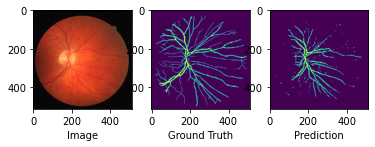

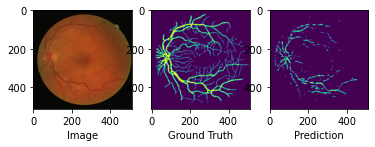

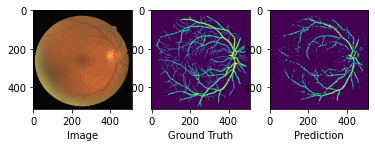

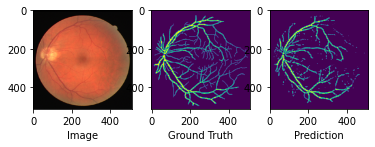

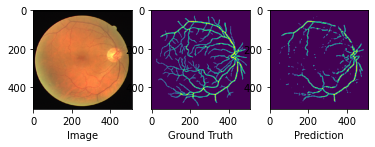

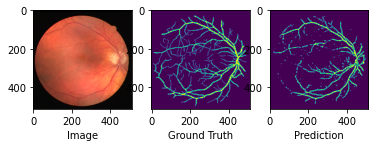

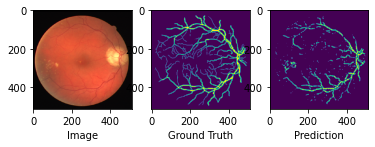

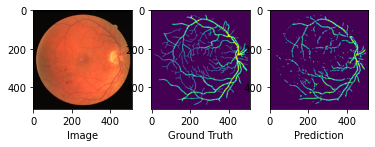

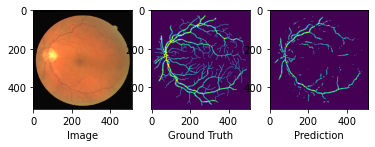

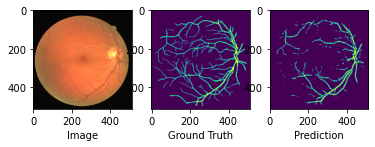

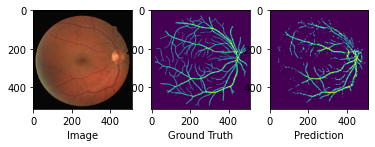

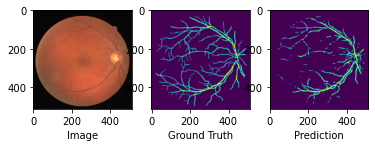

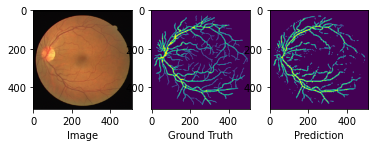

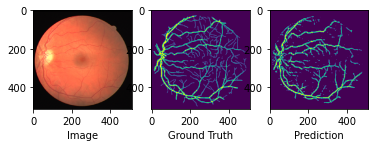

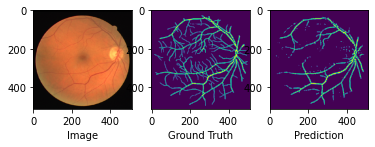

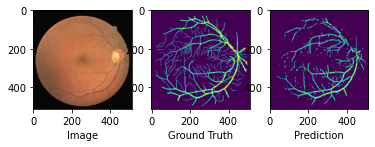

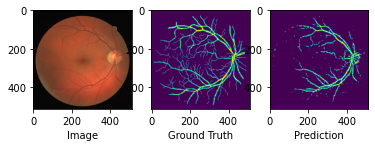

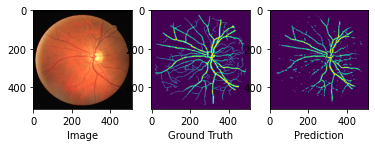

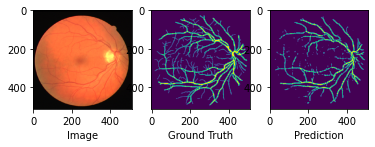

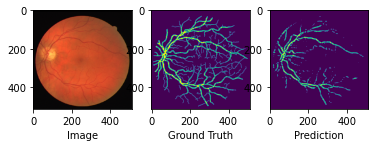

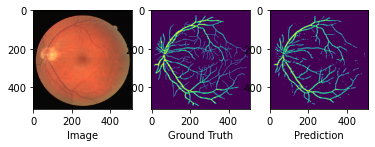

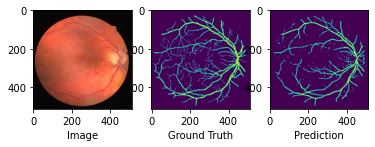

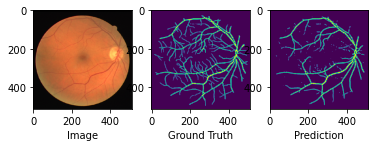

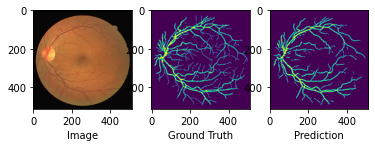

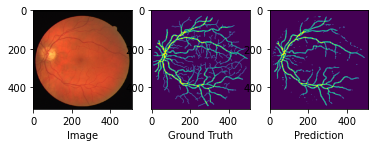

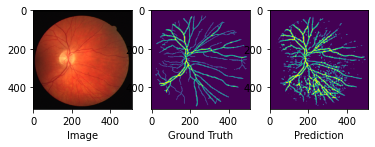

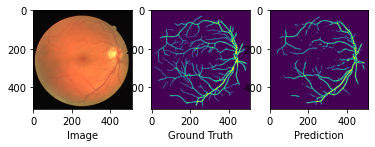

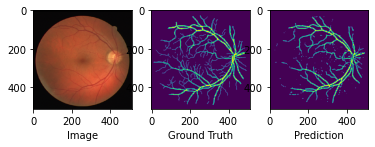

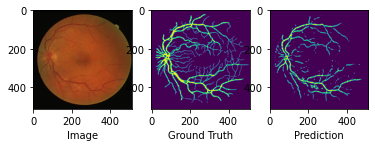

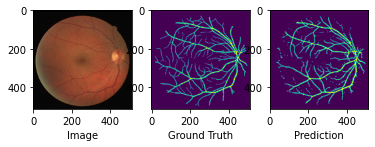

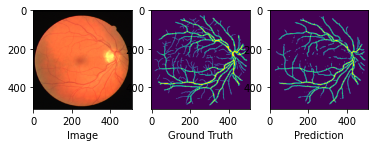

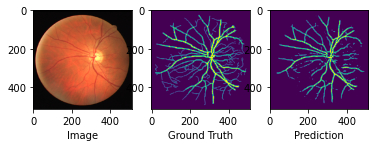

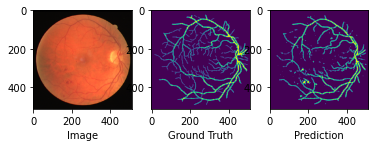

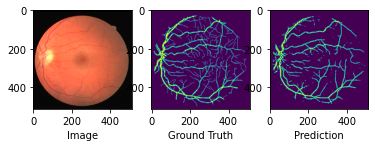

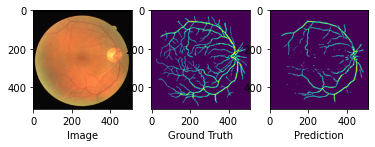

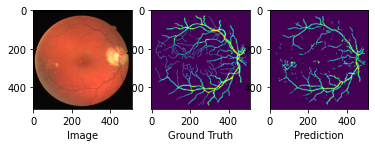

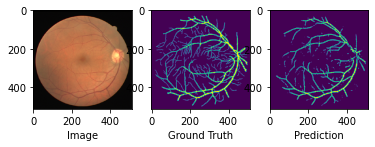

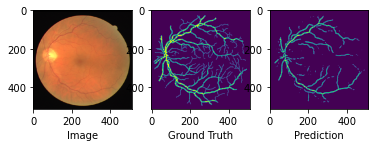

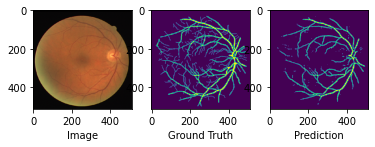

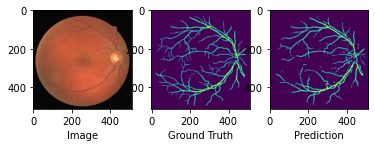

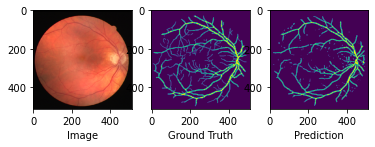

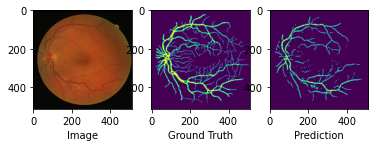

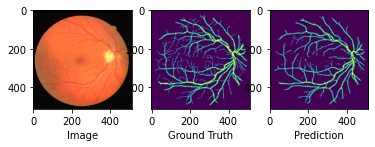

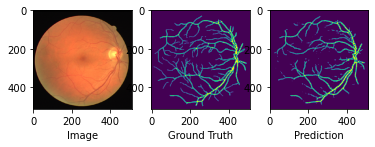

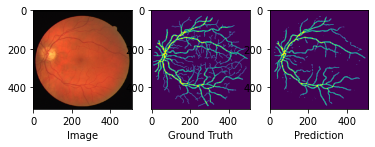

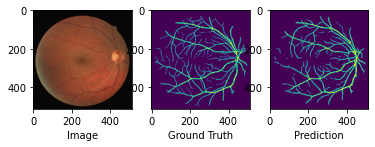

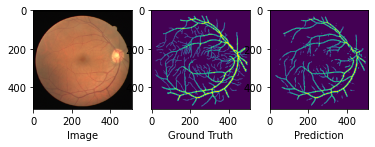

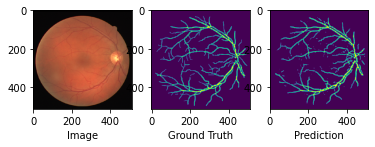

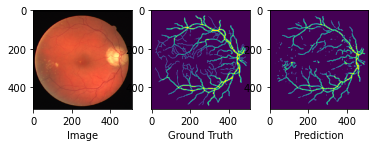

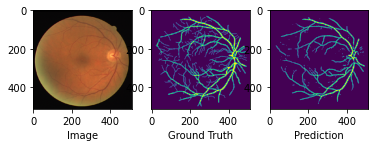

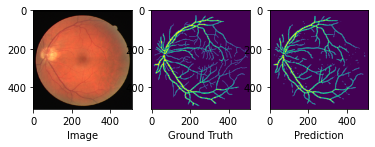

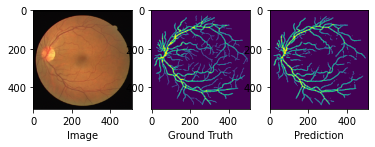

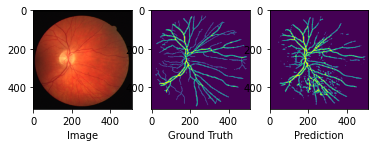

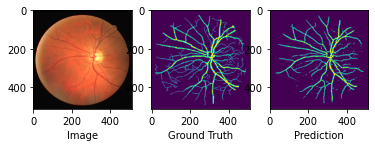

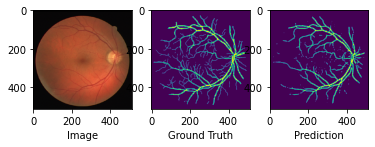

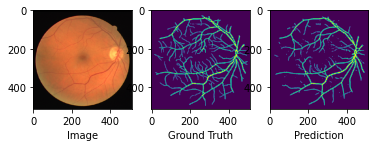

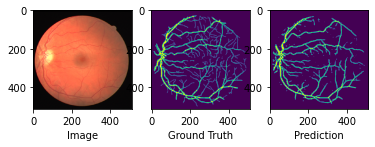

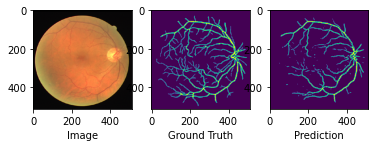

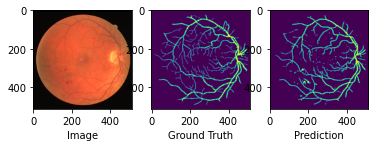

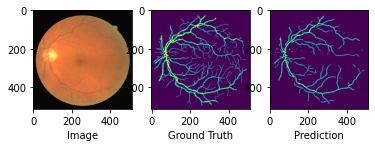

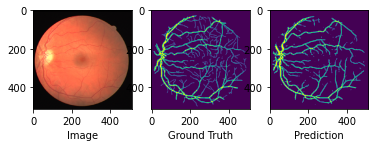

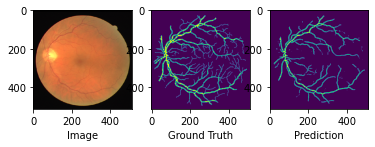

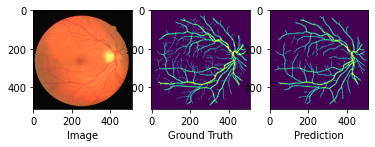

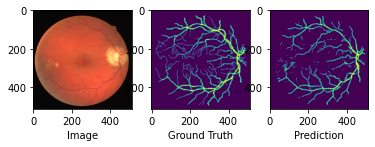

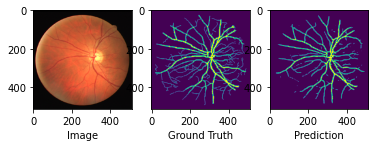

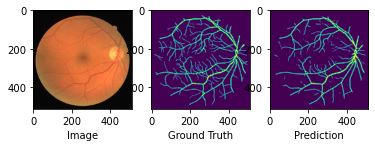

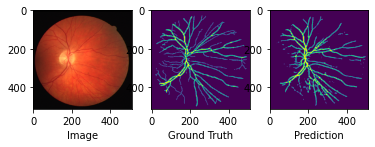

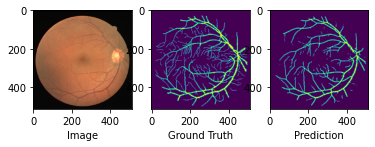

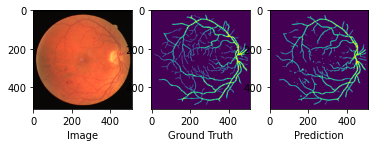

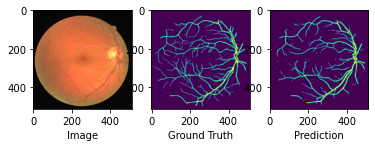

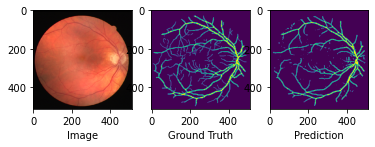

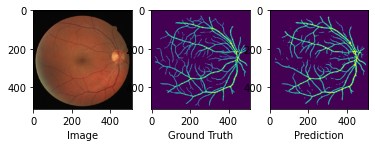

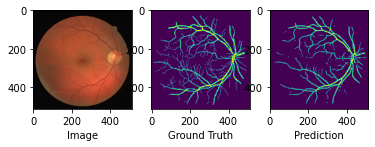

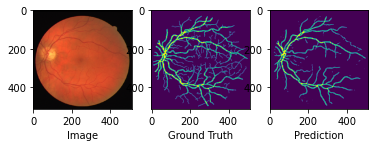

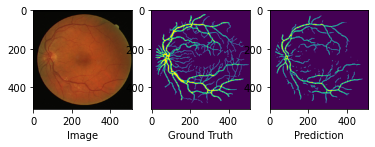

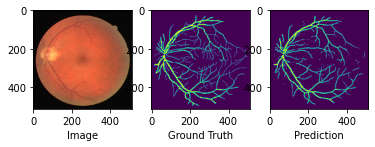

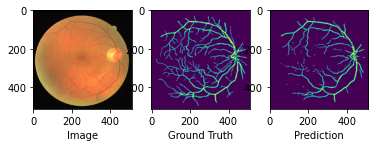

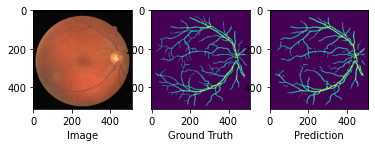

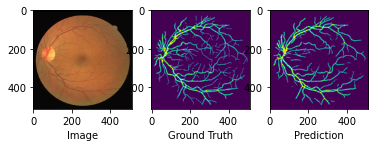

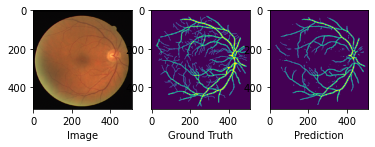

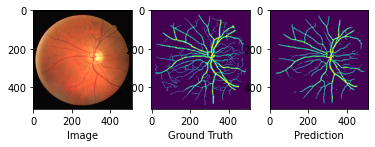

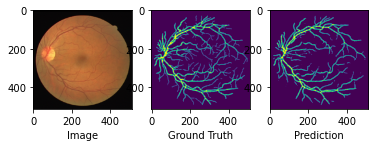

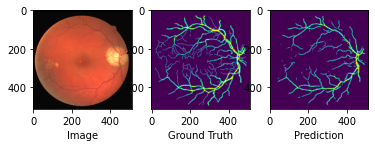

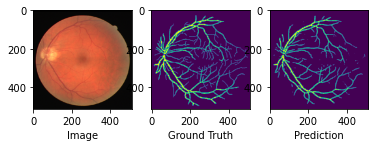

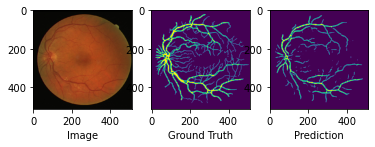

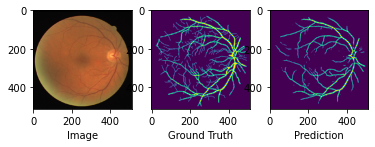

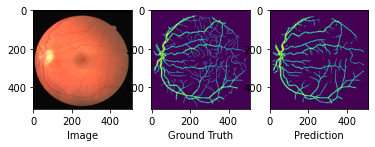

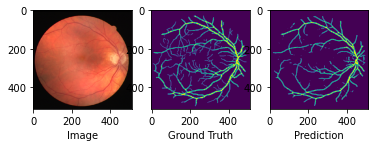

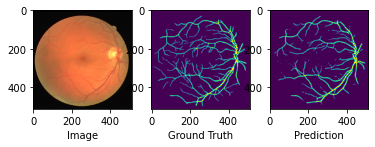

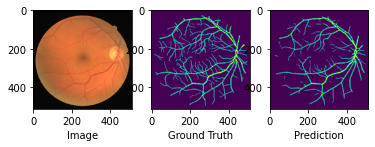

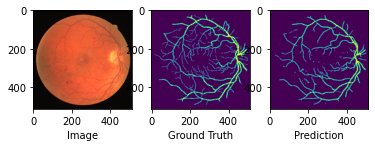

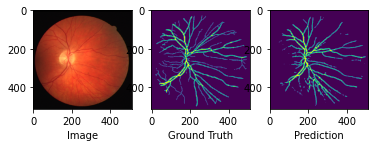

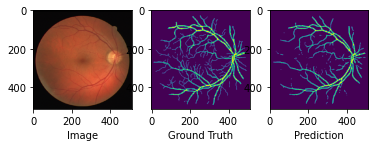

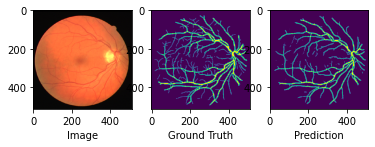

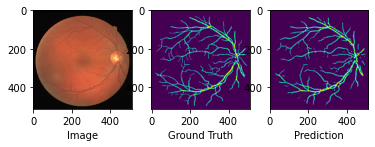

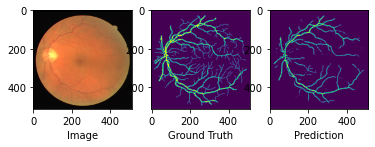

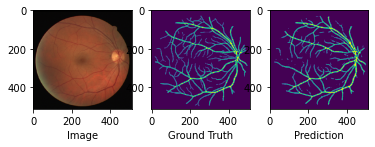

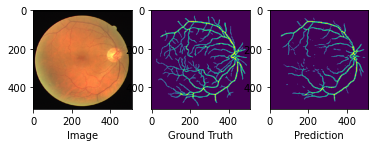

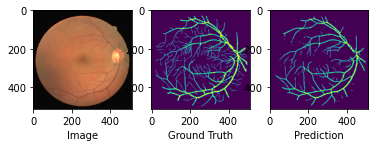

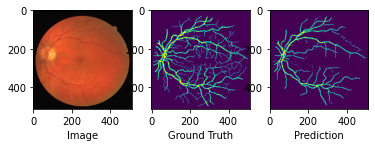

In [29]:
train_loss_values = []
valid_loss_values = []
train_iou_values = []
valid_iou_values = []

for epoch in range(EPOCHS):
    loop = tqdm(train_loader)
    train_losses = []
    train_iou = []
    # training_loop
    model.train()
    for batch_id, (images, masks) in enumerate(loop):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.unsqueeze(1)
        
        outputs = model(images.float())
        

        loss = criterion(outputs, masks)
        train_losses.append(loss.item())
        
        iou = mIoU(outputs, masks)
        train_iou.append(iou)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss=loss.item(), train_miou=iou)
        
    # Validation loop    
    model.eval()
    valid_losses = []
    valid_iou = []

    with torch.no_grad():
        loop = tqdm(valid_loader)
        for i, (images, masks) in enumerate(loop):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.unsqueeze(1)

            outputs = model(images.float())
            
            if (epoch+1) % 10 == 0:
                img = images[0].permute(1, 2, 0).cpu()
                mask = masks[0].squeeze(0).cpu()
                preds = torch.sigmoid(outputs)
                preds = (preds > 0.5).float()
                pred = preds[0].cpu().squeeze(0)

                plot_images(img, mask, pred)
            
            val_loss = criterion(outputs, masks)
            valid_losses.append(val_loss.item())

            val_iou = mIoU(outputs, masks)
            valid_iou.append(val_iou)
            
            loop.set_postfix(valid_loss=val_loss.item(), valid_miou=val_iou)
                
        
        
    scheduler.step()
        
    train_loss_values.append(np.mean(train_losses))
    valid_loss_values.append(np.mean(valid_losses))
    train_iou_values.append(np.mean(train_iou))
    valid_iou_values.append(np.mean(valid_iou))
    
    
    # if (epoch+1) % 10 == 0:
    torch.save(model.state_dict(), "drive_unet.pt")
        
        
        
        
    print(f"Epoch-{epoch+1} Train mean loss: {np.mean(train_losses):.4f} Train MIOU: {np.mean(train_iou):.4f}")
    print(f"Epoch-{epoch+1} Valid mean loss: {np.mean(valid_losses):.4f} Valid MIOU: {np.mean(valid_iou):.4f}")

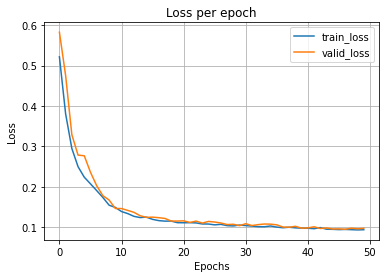

In [35]:
#Plotting Loss
plt.plot(train_loss_values, label='train_loss')
plt.plot(valid_loss_values, label='valid_loss')
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

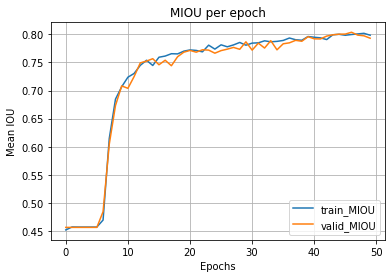

In [36]:
# Plotting Mean IOU
plt.plot(train_iou_values, label='train_MIOU')
plt.plot(valid_iou_values, label='valid_MIOU')
plt.title('MIOU per epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.legend()
plt.grid()
plt.show()

In [37]:
# inference_model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
weights = torch.load("drive_unet.pt")
model.load_state_dict(weights)



def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


model.eval()
with torch.no_grad():
    total_list = []
    for batch_id, (images, masks) in enumerate (tqdm(valid_loader)):
        images = images.float().to(DEVICE)
        masks = masks.to(DEVICE).squeeze(1).long()
        
        outputs = model(images)
        miou_list = mIoU(pred_mask = outputs, mask=masks, n_classes=2) 
        total_list.append(miou_list)
print(np.mean(total_list))

100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

0.7932542147224456


In [33]:
# inference_model = ConvMixer_UNET_down(CLASSES).to(DEVICE)
weights = torch.load("drive_unet.pt")
model.load_state_dict(weights)



def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


model.eval()
with torch.no_grad():
    total_list = []
    for batch_id, (images, masks) in enumerate (tqdm(valid_loader)):
        images = images.float().to(DEVICE)
        masks = masks.to(DEVICE).squeeze(1).long()
        
        outputs = model(images)
        miou_list = mIoU(pred_mask = outputs, mask=masks, n_classes=2) 
        total_list.append(miou_list)
print(np.mean(total_list))

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.86it/s]

0.7932542147224456


In [38]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unnorm = UnNormalize(mean=[0.4299, 0.4328, 0.3964], std=[0.2711, 0.2666, 0.2816])

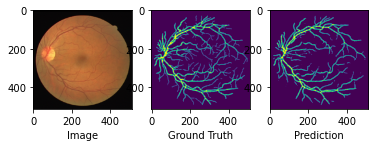

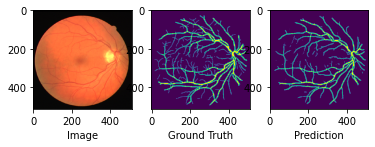

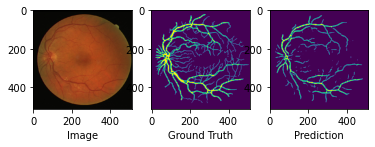

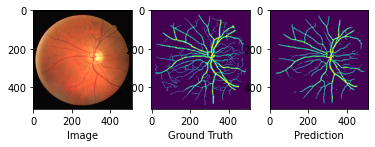

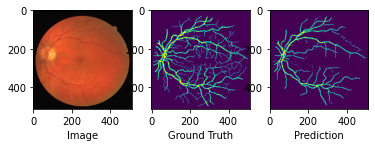

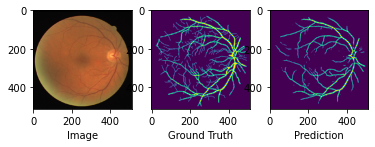

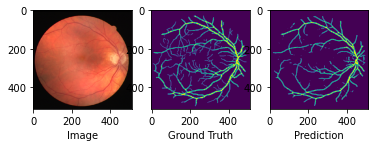

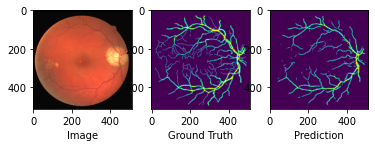

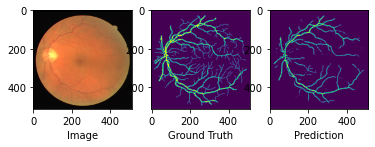

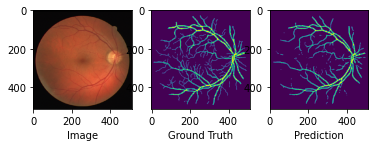

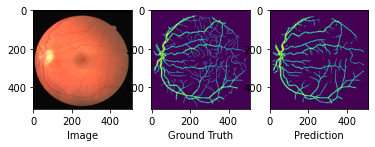

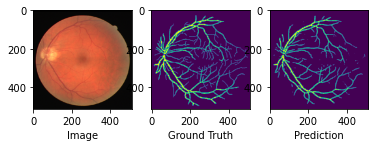

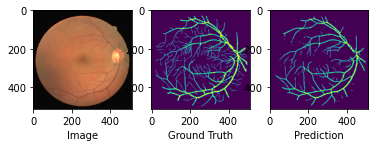

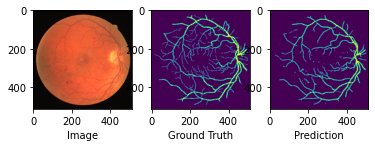

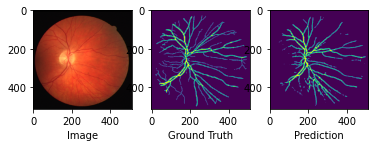

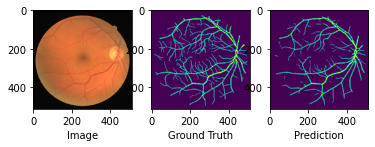

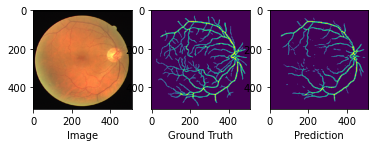

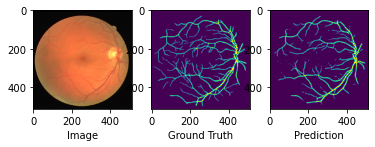

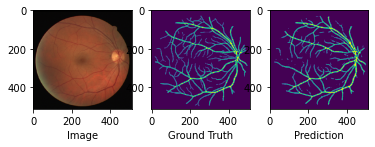

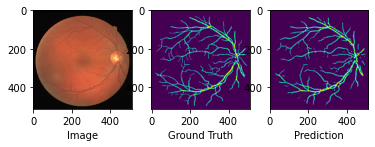

In [62]:
with torch.no_grad():
    model.eval()
    folder = 'predicted_images'
    for i, data in enumerate(valid_set):
        image, mask = data
        input = image.float().unsqueeze(0).to(DEVICE)
        mask = mask.float()

        output = model(input)
        pred = torch.sigmoid(output)
        pred = (pred > 0.5).float()
        pred = pred.cpu().squeeze(0).squeeze(0)
        mask[mask==1] = 255
        pred[pred == 1] = 255

        f, ax = plt.subplots(1, 3)
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_xlabel("Image")
        ax[1].imshow(mask)
        ax[1].set_xlabel("Ground Truth")
        ax[2].imshow(pred)
        ax[2].set_xlabel("Prediction")
        plt.savefig(f'predicted_images/image{i}')